# SENTIMENT ANALYSIS USING BERT

### Importing Essential Libraries

In [1]:
!pip install transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install contractions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import string
import unicodedata
from contractions import contractions_dict
import re
from nltk.corpus import wordnet
import collections
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from nltk.tokenize import word_tokenize

import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from sklearn.feature_extraction.text import CountVectorizer

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00


In [7]:
!pip install -qq transformers

In [8]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu118
transformers: 4.34.1



## Getting To Know the Data

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment_Analysis/reviews.csv')

In [10]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,eecc1d6f-2e1b-4d5c-bf06-e2ce6718c410,Krista Clark,https://play-lh.googleusercontent.com/a/ACg8oc...,"I used to love this app, but recently they did...",1,149,5.17.0.119,2023-07-02 17:35:08,You should only see the upgrade ad when you fi...,2023-07-03 09:28:29,5.17.0.119,most_relevant,com.anydo
1,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,38,4.12.0.5,2019-01-12 13:20:28,"We are sorry you feel this way, please note th...",2019-01-27 15:44:37,4.12.0.5,most_relevant,com.anydo
2,1177566d-6443-42ab-8320-7e8b3342cec8,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Product images show the month view at the top ...,1,12,NaN,2019-07-06 21:14:32,We appreciate the feedback. The images for iOS...,2019-07-09 11:45:56,NaN,most_relevant,com.anydo
3,82d2f0c3-dbff-4722-89fa-d8af997ba4ab,Hyco Syco,https://play-lh.googleusercontent.com/a/ACg8oc...,This app used to be great when paired with Ale...,1,10,4.15.9.6,2020-06-17 17:32:55,"Sorry about that, our team is currently workin...",2020-06-18 06:47:52,4.15.9.6,most_relevant,com.anydo
4,9f47e332-2c56-426c-8430-ce8ffde55706,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very annoyed that I have to keep signing in an...,1,27,4.15.8.11,2019-09-29 16:03:25,"Hi, that's odd, please send us a bug report in...",2019-10-02 19:51:43,4.15.8.11,most_relevant,com.anydo


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17592 entries, 0 to 17591
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17592 non-null  object
 1   userName              17592 non-null  object
 2   userImage             17592 non-null  object
 3   content               17592 non-null  object
 4   score                 17592 non-null  int64 
 5   thumbsUpCount         17592 non-null  int64 
 6   reviewCreatedVersion  14883 non-null  object
 7   at                    17592 non-null  object
 8   replyContent          9556 non-null   object
 9   repliedAt             9556 non-null   object
 10  appVersion            14883 non-null  object
 11  sortOrder             17592 non-null  object
 12  appId                 17592 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.7+ MB


In [12]:
df.shape

(17592, 13)

In [13]:
df['replyContent']

0        You should only see the upgrade ad when you fi...
1        We are sorry you feel this way, please note th...
2        We appreciate the feedback. The images for iOS...
3        Sorry about that, our team is currently workin...
4        Hi, that's odd, please send us a bug report in...
                               ...                        
17587                                                  NaN
17588                                                  NaN
17589                                                  NaN
17590    Hi, please contact us at planner.a@appxy.com, ...
17591                                                  NaN
Name: replyContent, Length: 17592, dtype: object

In [14]:
df['repliedAt']

0        2023-07-03 09:28:29
1        2019-01-27 15:44:37
2        2019-07-09 11:45:56
3        2020-06-18 06:47:52
4        2019-10-02 19:51:43
                ...         
17587                    NaN
17588                    NaN
17589                    NaN
17590    2022-12-19 01:28:21
17591                    NaN
Name: repliedAt, Length: 17592, dtype: object

In [15]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 'negative'
  elif rating == 3:
    return 'neutral'
  else:
    return 'positive'

## Exploratory Data Analysis

In [16]:
df.score.value_counts()

3    5698
1    3000
4    3000
5    3000
2    2894
Name: score, dtype: int64

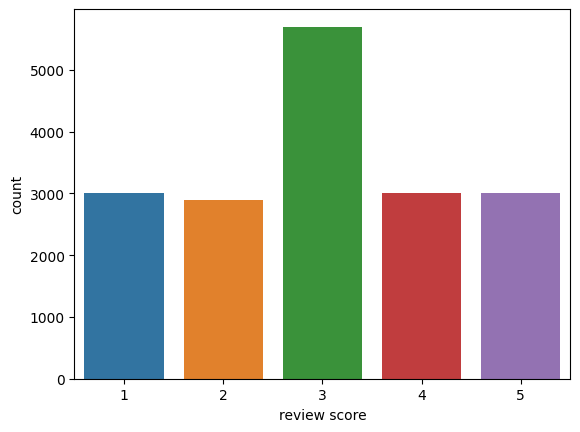

In [17]:
sns.countplot(x='score', data=df)
plt.xlabel('review score')
plt.show()

In [18]:
df['sentiment'] = df.score.apply(to_sentiment)

In [19]:
class_names = ['negative', 'neutral', 'positive']

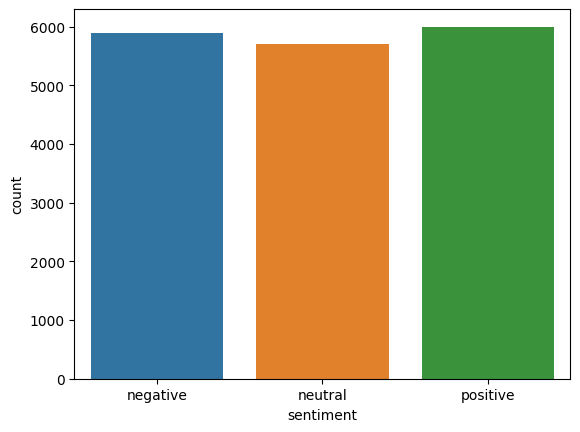

In [20]:
sns.countplot(x='sentiment', data=df)
plt.show()

In [21]:
pos = df[df['sentiment']=='positive']
neg = df[df['sentiment']=='negative']
neutral = df[df['sentiment']=='neutral']

Lets get the length of text and word counts of Positive, Negative and Neutral reviews.

In [22]:
pos['text_len'] = pos['content'].astype(str).apply(len)
pos['text_word_count'] = pos['content'].apply(lambda x: len(str(x).split()))

<ipython-input-22-b74b56bae23c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['text_len'] = pos['content'].astype(str).apply(len)
<ipython-input-22-b74b56bae23c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['text_word_count'] = pos['content'].apply(lambda x: len(str(x).split()))


In [23]:
neg['text_len'] = neg['content'].astype(str).apply(len)
neg['text_word_count'] = neg['content'].apply(lambda x: len(str(x).split()))

<ipython-input-23-a6e6569674b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['text_len'] = neg['content'].astype(str).apply(len)
<ipython-input-23-a6e6569674b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['text_word_count'] = neg['content'].apply(lambda x: len(str(x).split()))


In [24]:
neutral['text_len'] = neutral['content'].astype(str).apply(len)
neutral['text_word_count'] = neutral['content'].apply(lambda x: len(str(x).split()))

<ipython-input-24-8b222c851e6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral['text_len'] = neutral['content'].astype(str).apply(len)
<ipython-input-24-8b222c851e6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral['text_word_count'] = neutral['content'].apply(lambda x: len(str(x).split()))


Let's Visualize our results to get a better understanding of our data

Creating Histogram for Positive Reviews Text Length Distribution to get detailed view of the data distribution, showing the frequency of data points in various bins or intervals. Histograms are excellent for visualizing the data's shape

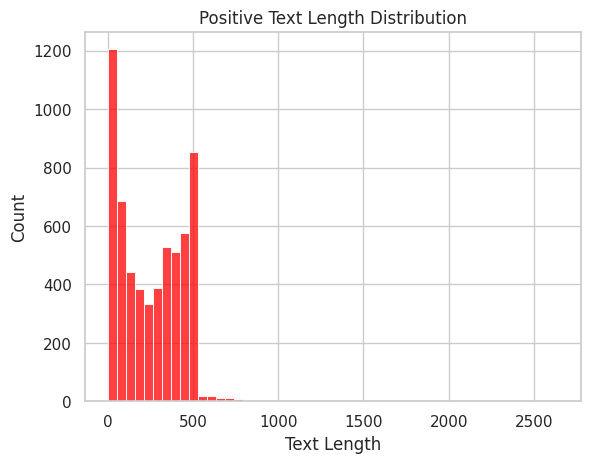

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a histogram
sns.histplot(data=pos, x="text_len", bins=50, color='red', kde=False)

# Add titles and labels
plt.title("Positive Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Count")

# Show the plot
plt.show()

In [25]:
# import plotly.graph_objs as go
# #Creating Histogram for Positive Reviews Text Length Distribution

# # Create a histogram trace(specific visualization component within a plot)
# trace = go.Histogram(
#     x=pos['text_len'],
#     nbinsx=100,  # Number of bins
#     marker=dict(color='red', line=dict(color='black', width=1)),
#     name='Text Length Distribution'
# )

# # Create a layout for the plot
# layout = go.Layout(
#     title='Positive Text Length Distribution',
#     xaxis=dict(title='Text Length'),
#     yaxis=dict(title='Count')
# )

# # Create a figure and plot it
# fig = go.Figure(data=[trace], layout=layout)
# fig.show()

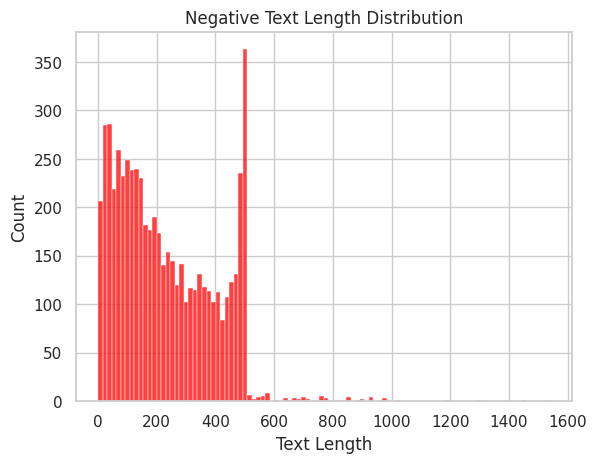

In [55]:
# Create a histogram
sns.histplot(data=neg, x="text_len", bins=100, color='red', kde=False)

# Add titles and labels
plt.title("Negative Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Count")

# Show the plot
plt.show()

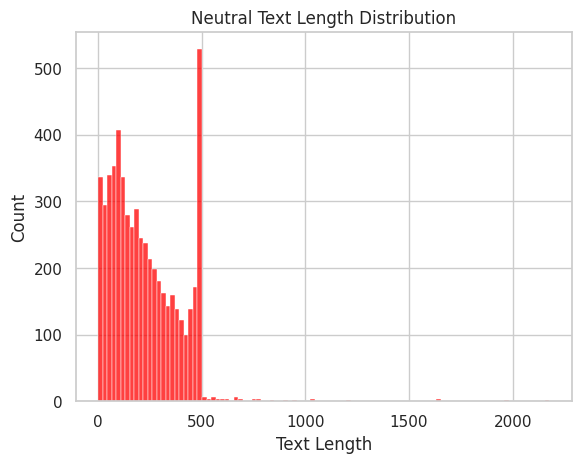

In [56]:
# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a histogram
sns.histplot(data=neutral, x="text_len", bins=100, color='red', kde=False)

# Add titles and labels
plt.title("Neutral Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Count")

# Show the plot
plt.show()

Box Plots:
Box plots, offer a compact and informative summary of the data distribution.

 Box plots display summary statistics, such as the median, quartiles (Q1 and Q3), and potential outliers. This information is valuable for understanding the central tendency, spread, and skewness of the data

 Box plots also include "whiskers" that extend to the minimum and maximum values within a specified range (commonly 1.5 times the interquartile range, IQR). Data points beyond the whiskers are considered potential outliers, making it easy to identify extreme values in the dataset.

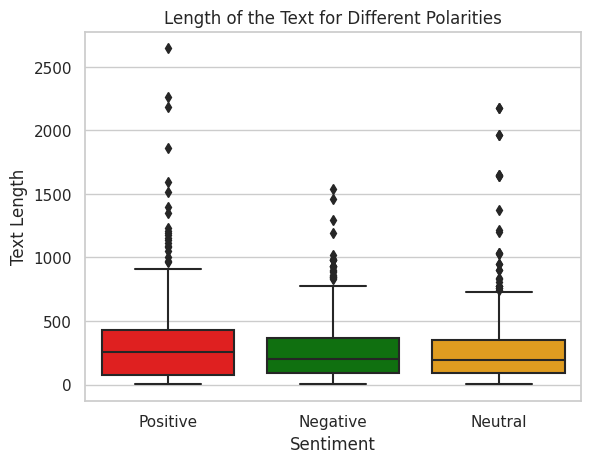

In [57]:
# Combine the data from the three categories into one DataFrame
combined_data = pd.concat([pos.assign(category='Positive'), neg.assign(category='Negative'), neutral.assign(category='Neutral')])

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a box plot
sns.boxplot(data=combined_data, x='category', y='text_len', palette=["red", "green", "orange"])

# Add titles and labels
plt.title("Length of the Text for Different Polarities")
plt.xlabel("Sentiment")
plt.ylabel("Text Length")

# Show the plot
plt.show()

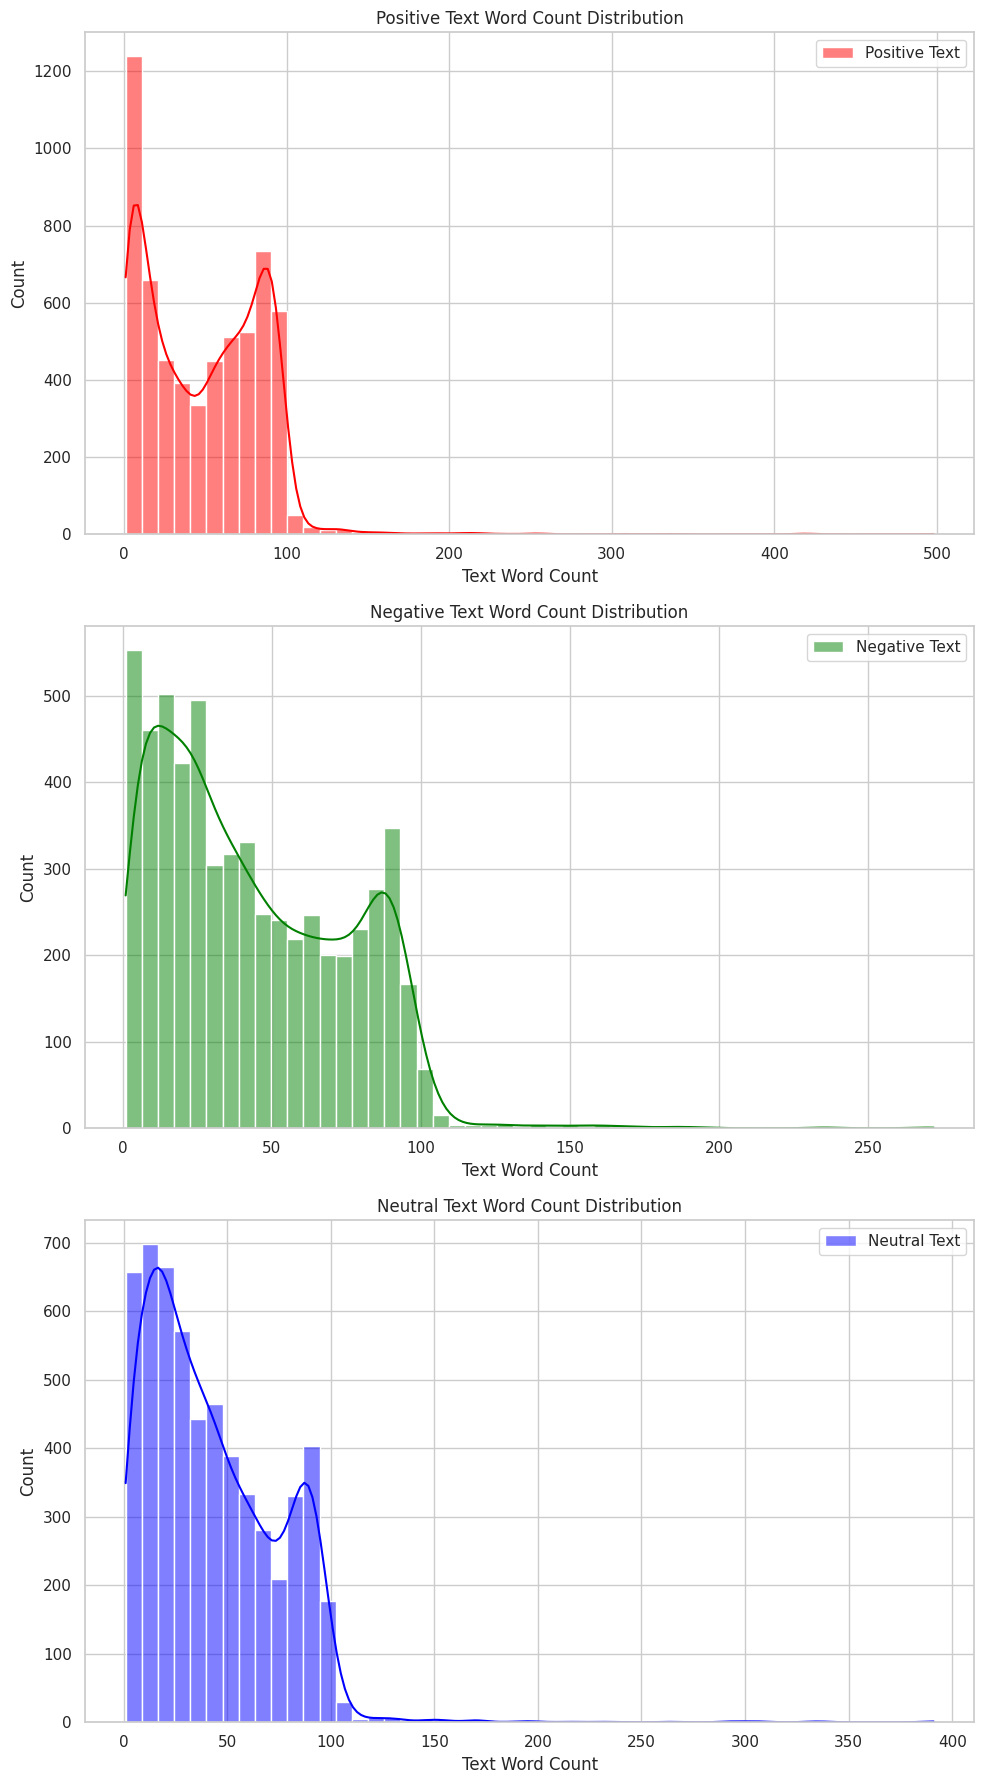

In [60]:
# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create subplots for each polarity
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Create histograms for positive, negative, and neutral text word counts
sns.histplot(data=pos, x="text_word_count", bins=50, color='red', label='Positive Text', kde=True, ax=axes[0])
sns.histplot(data=neg, x="text_word_count", bins=50, color='green', label='Negative Text', kde=True, ax=axes[1])
sns.histplot(data=neutral, x="text_word_count", bins=50, color='blue', label='Neutral Text', kde=True, ax=axes[2])

# Add titles and labels to each subplot
axes[0].set_title("Positive Text Word Count Distribution")
axes[1].set_title("Negative Text Word Count Distribution")
axes[2].set_title("Neutral Text Word Count Distribution")

for ax in axes:
    ax.set_xlabel("Text Word Count")
    ax.set_ylabel("Count")
    ax.legend()  # Show legend in each subplot

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-64-178155a07ae0>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-64-178155a07ae0>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-64-178155a07ae0>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



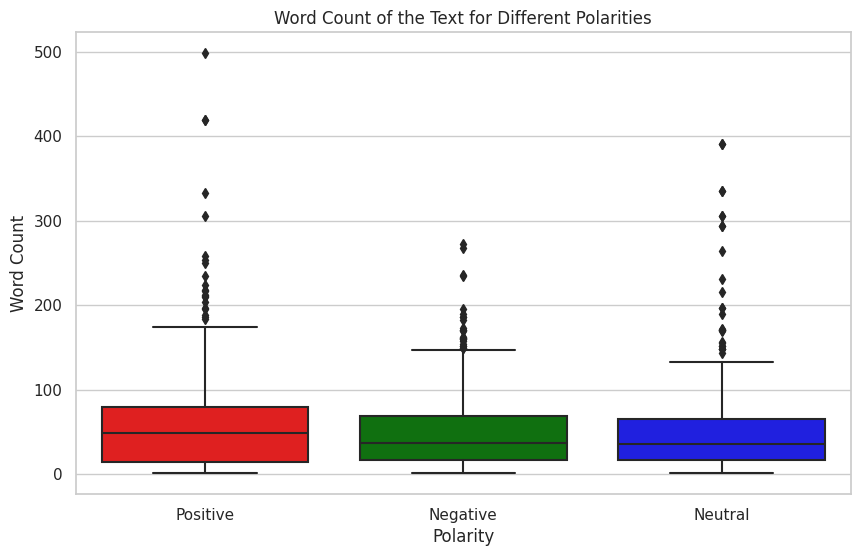

In [64]:
# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Combine the data into one DataFrame with a "Polarity" column
pos['Polarity'] = 'Positive'
neg['Polarity'] = 'Negative'
neutral['Polarity'] = 'Neutral'
combined_data = pd.concat([pos, neg, neutral])

# Create a box plot for text word counts by polarity
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(x="Polarity", y="text_word_count", data=combined_data, palette=["red", "green", "blue"])

# Add titles and labels
plt.title("Word Count of the Text for Different Polarities")
plt.xlabel("Polarity")
plt.ylabel("Word Count")

# Show the plot
plt.show()


## Text Preprocessing

Text needs to be preprocessed as part of data cleaning and preparation for NLP tasks. Here, we perform various operations, such as removing HTML tags, stop words, and special characters, expanding contractions, removing accented characters, stemming, and lemmatization to enhance the quality and consistency of textual data for analysis.

In [31]:

# remove html tage if any
def remove_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    if bool(soup.find()):
        [s.extract() for s in soup(['iframe', 'script'])]
        stripped_text = soup.get_text()
        stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    else:
        stripped_text = text
    return stripped_text


In [32]:
# removing stop words (is, a...)
def rem_stop(sent):
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(sent)

    cleansent = [w for w in word_tokens if not w.lower() in stop_words]

    cleansent = []

    for w in word_tokens:
         if w not in stop_words:
            cleansent.append(w)
    cleansent = ' '.join(cleansent)
    return cleansent

In [33]:
# Don't -> Do not, I'd -> I would
def expand_contractions(text):

    expanded_words = []
    for word in text.split():
  # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))

    expanded_text = ' '.join(expanded_words)
    return expanded_text


In [34]:
# converting é to e.
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


In [35]:
#stemming
def stem(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
#Lemmatization
def lemmatize_text(text):
    wnl = WordNetLemmatizer()
    list1 = nltk.word_tokenize(text)
    lemmatized_string = ' '.join([wnl.lemmatize(words) for words in list1])
    return lemmatized_string


In [36]:
#Make text lowercase, remove text in square brackets,remove punctuation
#and remove words containing numbers.

def remove_special_characters(text, remove_digits=False):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text


In [37]:
def preprocess_text(sen, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True,
                     text_lemmatization=False, remove_digits=True,
                     special_char_removal = True,
                     stopword_removal=False, stem = False):

    if html_stripping:
            sen = remove_tags(sen)
    if accented_char_removal:
            sen = remove_accented_chars(sen)

    if contraction_expansion:
            sen = expand_contractions(sen)

    if text_lemmatization:
            sen = lemmatize_text(sen)

    if special_char_removal:
            special_char_pattern = re.compile(r'([{.(-)!}])')
            sen = special_char_pattern.sub(" \\1 ", sen)
            sen = remove_special_characters(sen, remove_digits=remove_digits)

    if text_lower_case:
            sen = sen.lower()

    if stopword_removal:
            sen = rem_stop(sen)
    if stem:
            sen = stem(sen)

    return sen


In [38]:
pos['text_clean'] = pos['content'].apply(str).apply(lambda x: preprocess_text(x))
neg['text_clean'] = neg['content'].apply(str).apply(lambda x: preprocess_text(x))
neutral['text_clean'] = neutral['content'].apply(str).apply(lambda x: preprocess_text(x))


<ipython-input-38-e9a6c3478c9a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-e9a6c3478c9a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-e9a6c3478c9a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
neg.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,sentiment,text_len,text_word_count,text_clean
0,eecc1d6f-2e1b-4d5c-bf06-e2ce6718c410,Krista Clark,https://play-lh.googleusercontent.com/a/ACg8oc...,"I used to love this app, but recently they did...",1,149,5.17.0.119,2023-07-02 17:35:08,You should only see the upgrade ad when you fi...,2023-07-03 09:28:29,5.17.0.119,most_relevant,com.anydo,negative,373,73,i used to love this app but recently they did ...
1,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,38,4.12.0.5,2019-01-12 13:20:28,"We are sorry you feel this way, please note th...",2019-01-27 15:44:37,4.12.0.5,most_relevant,com.anydo,negative,498,96,this app was great until the latest update and...
2,1177566d-6443-42ab-8320-7e8b3342cec8,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Product images show the month view at the top ...,1,12,NaN,2019-07-06 21:14:32,We appreciate the feedback. The images for iOS...,2019-07-09 11:45:56,NaN,most_relevant,com.anydo,negative,495,90,product images show the month view at the top ...
3,82d2f0c3-dbff-4722-89fa-d8af997ba4ab,Hyco Syco,https://play-lh.googleusercontent.com/a/ACg8oc...,This app used to be great when paired with Ale...,1,10,4.15.9.6,2020-06-17 17:32:55,"Sorry about that, our team is currently workin...",2020-06-18 06:47:52,4.15.9.6,most_relevant,com.anydo,negative,465,92,this app used to be great when paired with ale...
4,9f47e332-2c56-426c-8430-ce8ffde55706,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very annoyed that I have to keep signing in an...,1,27,4.15.8.11,2019-09-29 16:03:25,"Hi, that's odd, please send us a bug report in...",2019-10-02 19:51:43,4.15.8.11,most_relevant,com.anydo,negative,454,90,very annoyed that i have to keep signing in an...


## N-Gram Analysis

Analyzing n-grams is essential in NLP to understand word frequency, context, and relationships between words, aiding sentiment analysis as well as other text processing and analytics tasks.

Uni-grams (univariate distributions) are single words, while bi-grams are pairs of consecutive words. They provide insights into language patterns and help extract meaningful information from text data.

In [40]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [42]:
pos_unigrams = get_top_n_words(pos['text_clean'],20)
neg_unigrams = get_top_n_words(neg['text_clean'],20)
neutral_unigrams = get_top_n_words(neutral['text_clean'],20)

In [43]:
pos_bigrams = get_top_n_gram(pos['text_clean'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['text_clean'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['text_clean'],(2,2),20)


In [44]:
pos_trigrams = get_top_n_gram(pos['text_clean'],(3,3),20)
neg_trigrams = get_top_n_gram(neg['text_clean'],(3,3),20)
neutral_trigrams = get_top_n_gram(neutral['text_clean'],(3,3),20)

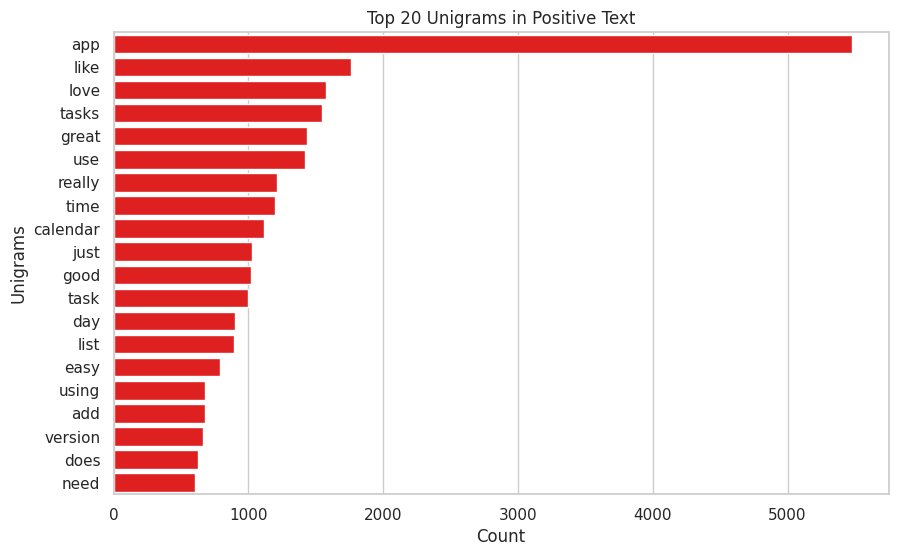

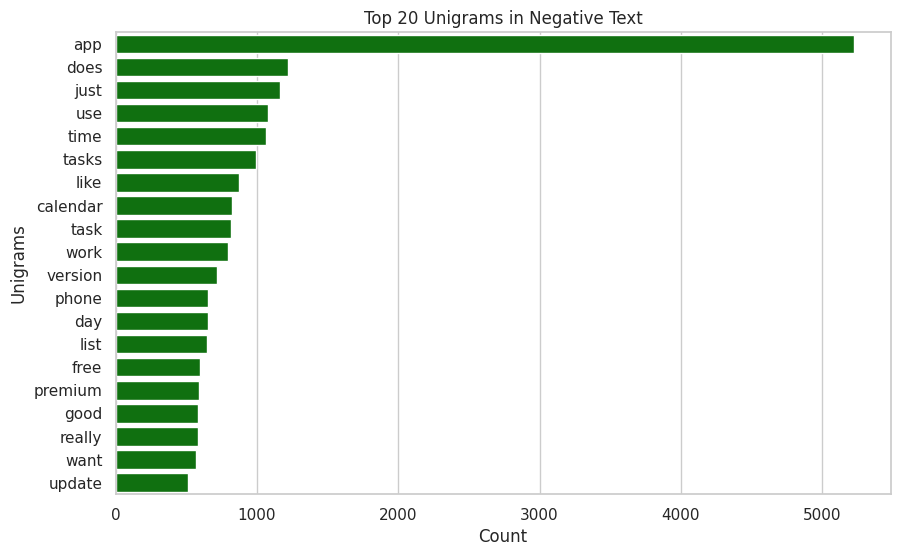

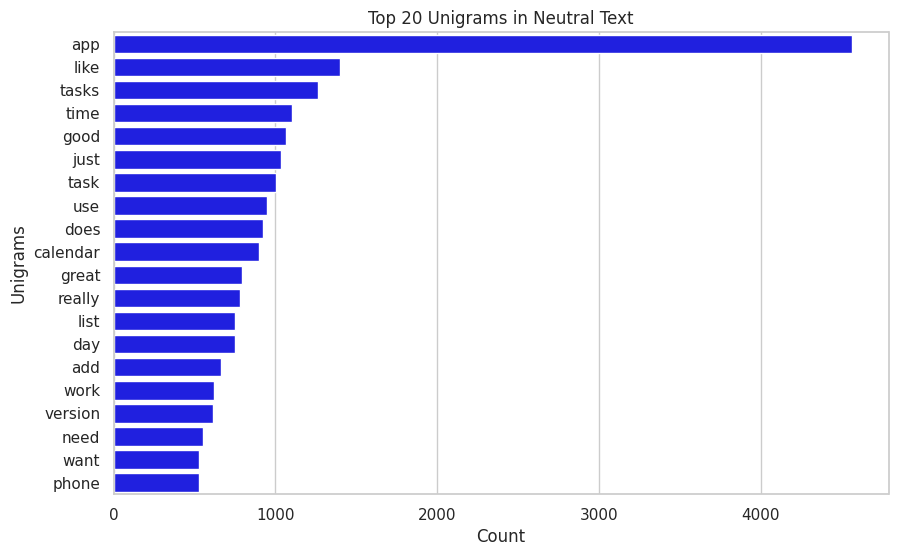

In [67]:
# Define a custom color palette
colors = ["red", "green", "blue"]

# Function to create a bar plot for top n-grams
def create_bar_plot(ngrams, title, color):
    df = pd.DataFrame(ngrams, columns=['Text', 'count'])
    df_grouped = df.groupby('Text').sum()['count'].sort_values(ascending=False).head(20)  # Sort and take the top 20

    plt.figure(figsize=(10, 6))
    sns.barplot(x=df_grouped.values, y=df_grouped.index, palette=[color])

    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Unigrams')

    plt.show()



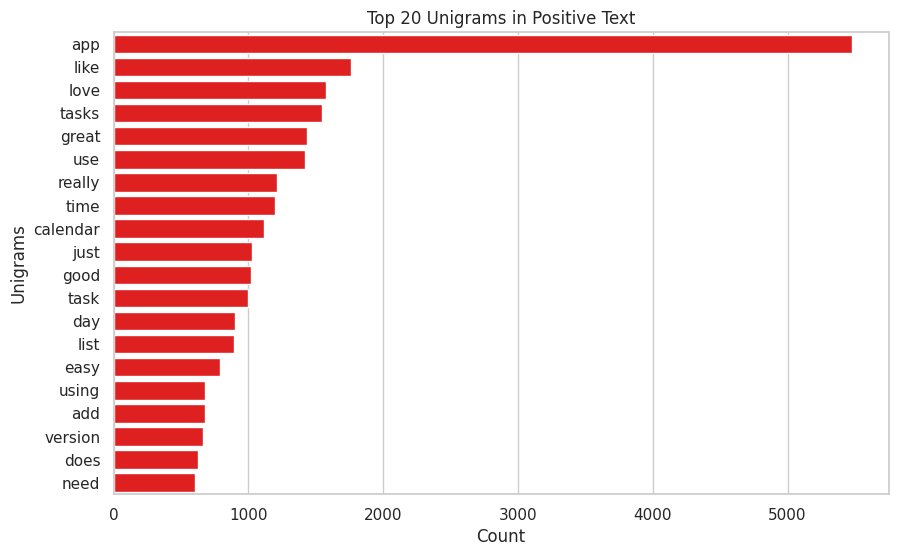

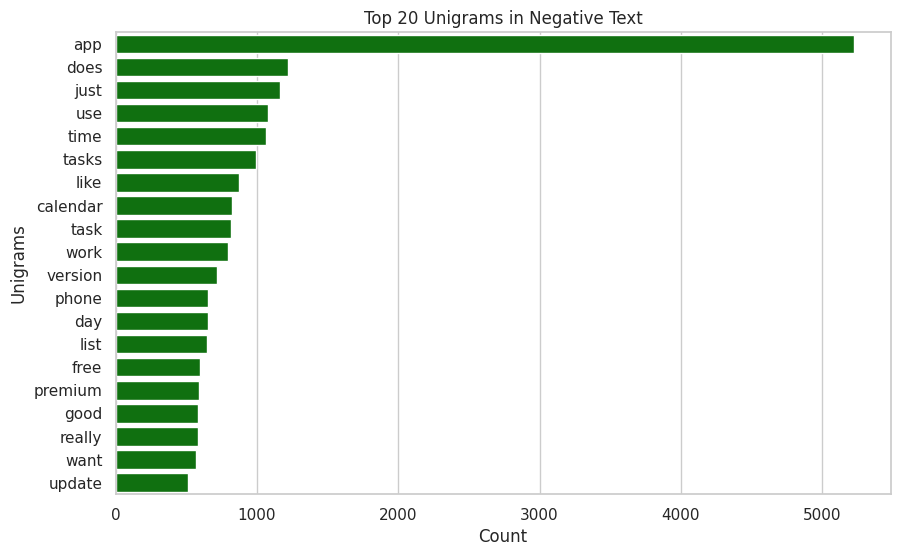

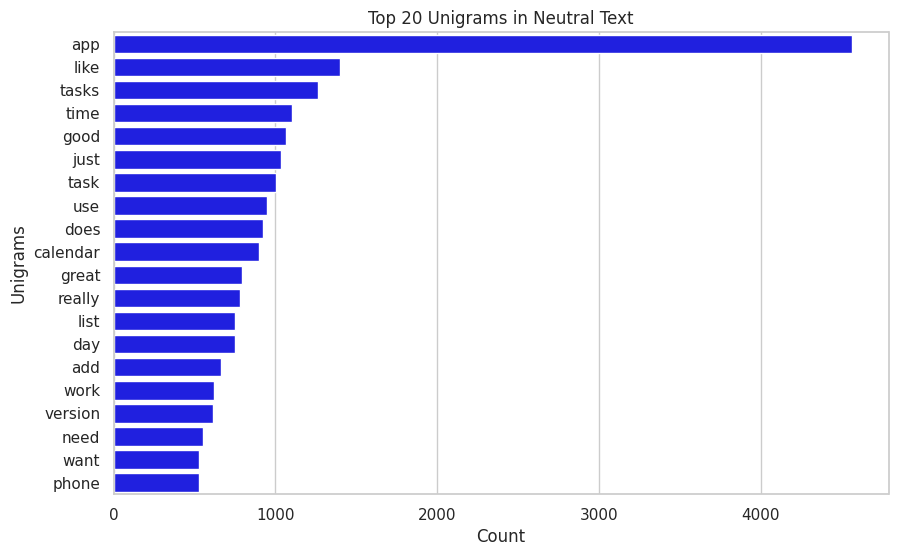

In [68]:
# Create bar plots for top 20 unigrams in positive, negative, and neutral text
create_bar_plot(pos_unigrams, 'Top 20 Unigrams in Positive Text', colors[0])
create_bar_plot(neg_unigrams, 'Top 20 Unigrams in Negative Text', colors[1])
create_bar_plot(neutral_unigrams, 'Top 20 Unigrams in Neutral Text', colors[2])

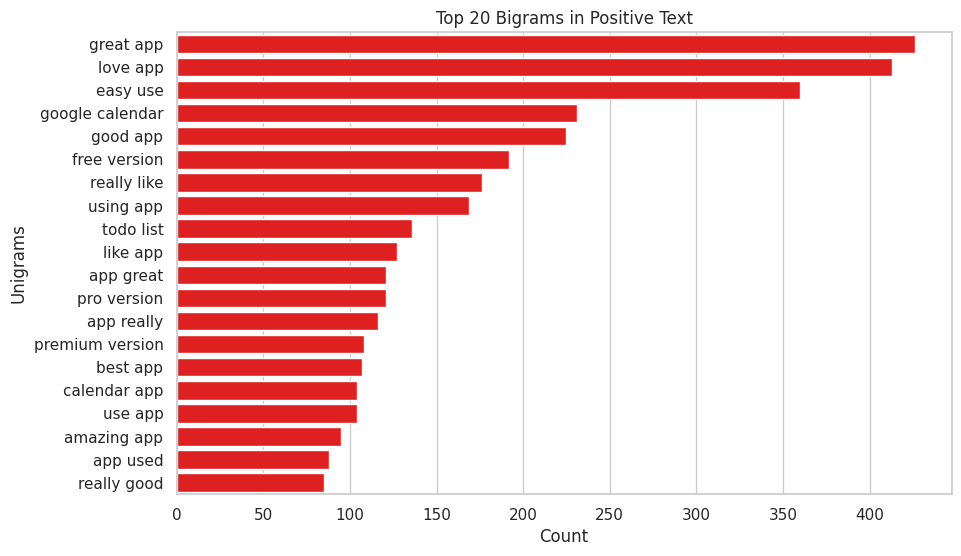

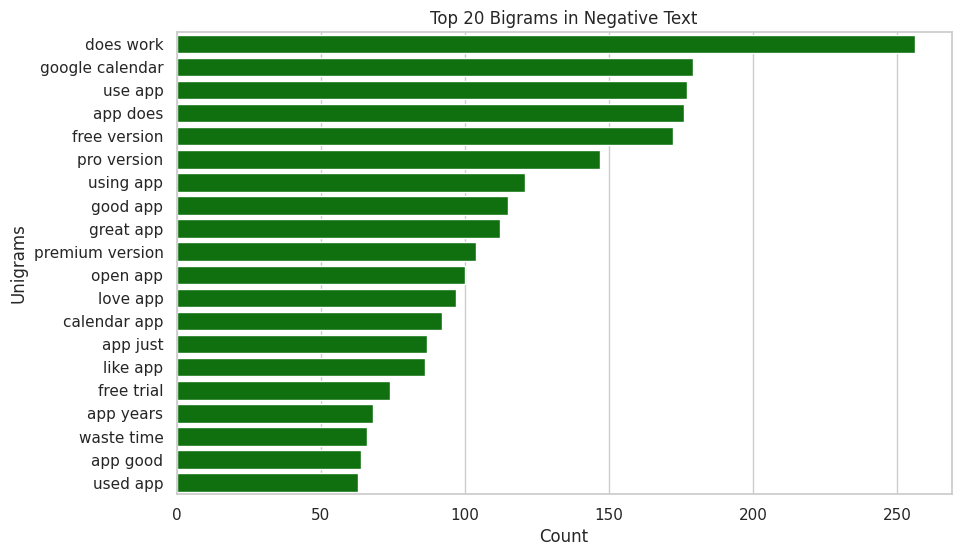

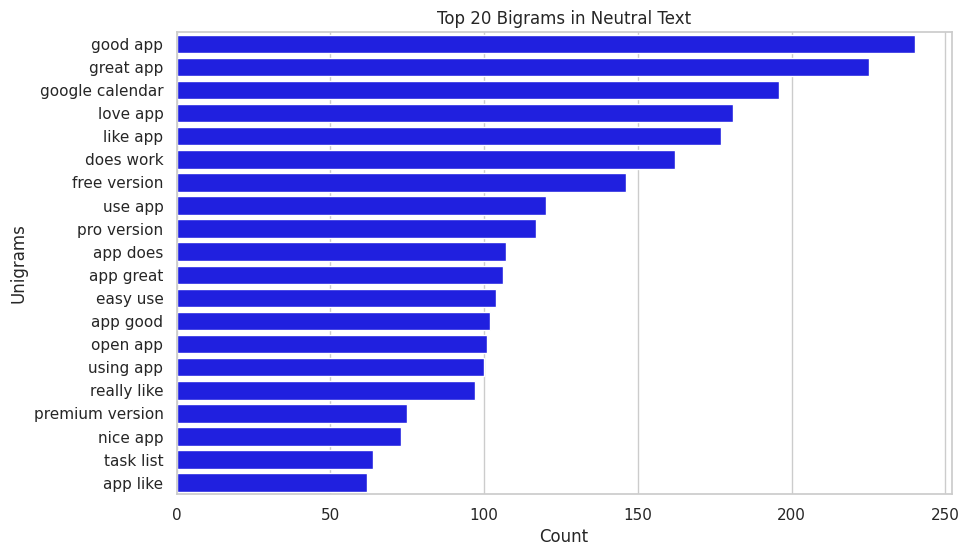

In [69]:
# Create bar plots for top 20 bigrams in positive, negative, and neutral text
create_bar_plot(pos_bigrams, 'Top 20 Bigrams in Positive Text', colors[0])
create_bar_plot(neg_bigrams, 'Top 20 Bigrams in Negative Text', colors[1])
create_bar_plot(neutral_bigrams, 'Top 20 Bigrams in Neutral Text', colors[2])



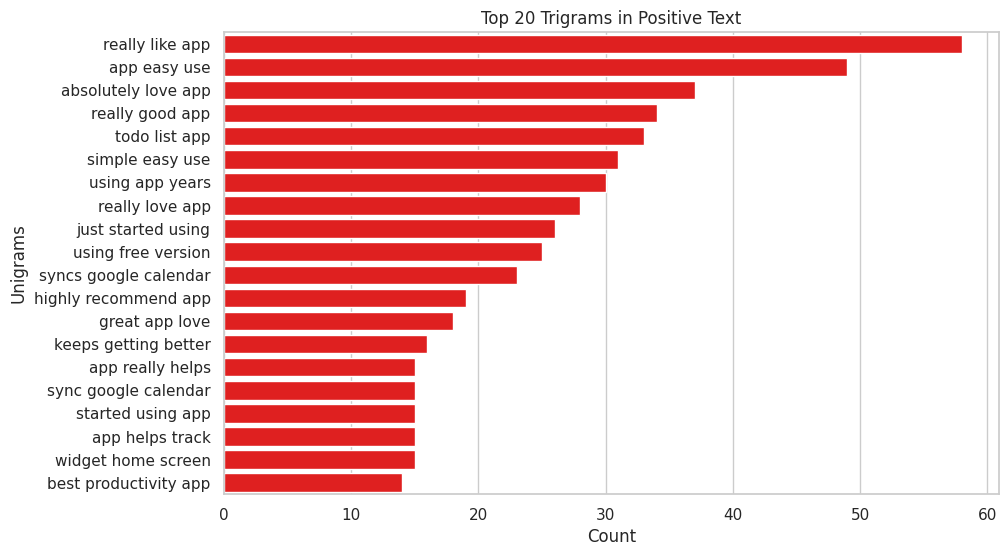

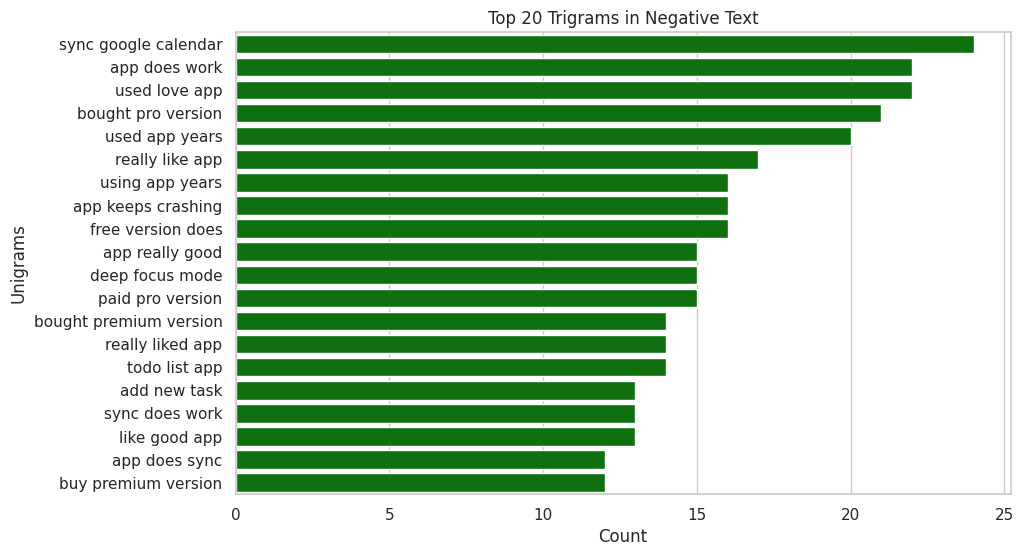

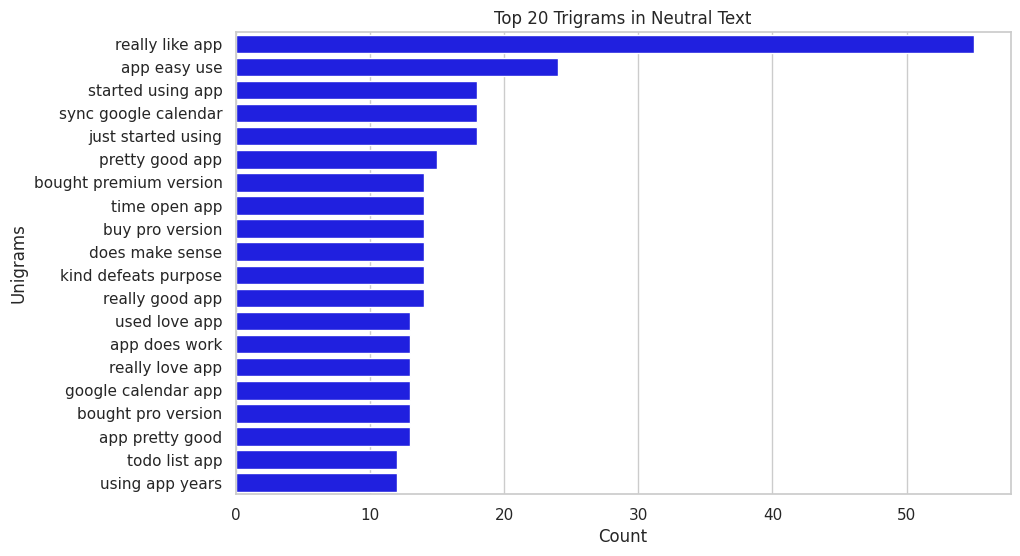

In [70]:
# Create bar plots for top 20 trigrams in positive, negative, and neutral text
create_bar_plot(pos_trigrams, 'Top 20 Trigrams in Positive Text', colors[0])
create_bar_plot(neg_trigrams, 'Top 20 Trigrams in Negative Text', colors[1])
create_bar_plot(neutral_trigrams, 'Top 20 Trigrams in Neutral Text', colors[2])

Data Processing for BERT

In [49]:
#Encoding the target
df['sentiment'] = df.sentiment.apply(lambda x: 2 if x == 'positive' else (1 if x == 'neutral' else 0))  # Convert sentiment labels to integers

In [50]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,sentiment
0,eecc1d6f-2e1b-4d5c-bf06-e2ce6718c410,Krista Clark,https://play-lh.googleusercontent.com/a/ACg8oc...,"I used to love this app, but recently they did...",1,149,5.17.0.119,2023-07-02 17:35:08,You should only see the upgrade ad when you fi...,2023-07-03 09:28:29,5.17.0.119,most_relevant,com.anydo,0
1,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,38,4.12.0.5,2019-01-12 13:20:28,"We are sorry you feel this way, please note th...",2019-01-27 15:44:37,4.12.0.5,most_relevant,com.anydo,0
2,1177566d-6443-42ab-8320-7e8b3342cec8,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Product images show the month view at the top ...,1,12,NaN,2019-07-06 21:14:32,We appreciate the feedback. The images for iOS...,2019-07-09 11:45:56,NaN,most_relevant,com.anydo,0
3,82d2f0c3-dbff-4722-89fa-d8af997ba4ab,Hyco Syco,https://play-lh.googleusercontent.com/a/ACg8oc...,This app used to be great when paired with Ale...,1,10,4.15.9.6,2020-06-17 17:32:55,"Sorry about that, our team is currently workin...",2020-06-18 06:47:52,4.15.9.6,most_relevant,com.anydo,0
4,9f47e332-2c56-426c-8430-ce8ffde55706,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very annoyed that I have to keep signing in an...,1,27,4.15.8.11,2019-09-29 16:03:25,"Hi, that's odd, please send us a bug report in...",2019-10-02 19:51:43,4.15.8.11,most_relevant,com.anydo,0


BERT models come in two primary versions: cased and uncased.

Cased BERT models use the original casing of the words in the training data.

Input: "Welcome to Boston."
Tokenized Output: ["Welcome", "to", "Boston", "."]


Uncased BERT models convert all text to lowercase during training.

Input: "Welcome to Boston."
Tokenized Output: ["welcome", "to", "boston", "."]

For our sentiment analysis task we will be using the cased version.

In [51]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [53]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Let's start with a sample text and run it through

In [54]:
sample_txt = 'Hello, Welcome to Boston. So when are you planning to visit the famous Boston Public Garden?'

In [55]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Hello, Welcome to Boston. So when are you planning to visit the famous Boston Public Garden?
   Tokens: ['Hello', ',', 'Welcome', 'to', 'Boston', '.', 'So', 'when', 'are', 'you', 'planning', 'to', 'visit', 'the', 'famous', 'Boston', 'Public', 'Garden', '?']
Token IDs: [8667, 117, 12050, 1106, 2859, 119, 1573, 1165, 1132, 1128, 3693, 1106, 3143, 1103, 2505, 2859, 2710, 5217, 136]


In natural language processing and tokenization, "CLS," "SEP," "PAD," and "UNK" tokens are commonly used in models like BERT

[CLS] Token (Classification Token) is used at the beginning of a sequence to obtain a fixed-size representation of the entire input sequence.

[SEP] Token (Separator Token) is used to separate two different sentences or segments in the same input sequence. It tells the model that one segment ends, and the next one begins.

[PAD] Token (Padding Token) is used to pad sequences to a fixed length. In a batch of input sequences, those with shorter lengths are padded with [PAD] tokens to match the length of the longest sequence in the batch. This is necessary for efficient batch processing, as models require inputs of the same length.

[UNK] Token (Unknown Token) represents unknown words or tokens in the input text. When tokenizing a text, if a word or subword is not present in the vocabulary, it is replaced with the [UNK] token.

In [56]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [57]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [58]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [59]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

 We will now use the Hugging Face Transformers library to tokenize and encode a text using the BERT tokenizer. We will be using the input_ids and attention_mask from the encoding dictionary as inputs to your BERT model for further processing.

 These tensors represent the tokenized and encoded input text and its attention mask.

In [60]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys() #prints the keys of the encoding dictionary.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



dict_keys(['input_ids', 'attention_mask'])

In [61]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  8667,   117, 12050,  1106,  2859,   119,  1573,  1165,  1132,
         1128,  3693,  1106,  3143,  1103,  2505,  2859,  2710,  5217,   136,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [62]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [63]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Hello',
 ',',
 'Welcome',
 'to',
 'Boston',
 '.',
 'So',
 'when',
 'are',
 'you',
 'planning',
 'to',
 'visit',
 'the',
 'famous',
 'Boston',
 'Public',
 'Garden',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [64]:
# Lets get the length of tokens

token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

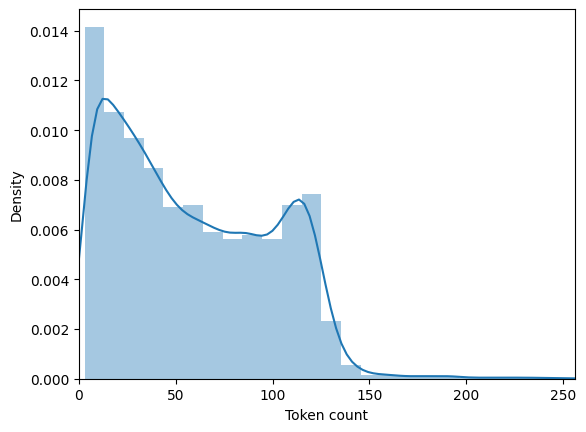

In [65]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

From the above plot we can visualize the lenghts of tokens. This will be helpfull for deciding the Maximum Length of tokens that is to be fed for our neural network.

Analyzing the above plot we can set Maximum lenghts as 200.

In [66]:
MAX_LEN = 200
BATCH_SIZE = 16

We now create a custom PyTorch dataset class for sentiment analysis.

Our method will return a Python dictionary with the following keys:

'review_text': The original text of the review.


'input_ids': The tokenized and padded input IDs.



'attention_mask': The attention mask indicating which tokens are real and which are padded.


'targets': The sentiment label as a PyTorch tensor.

In [67]:
class GPReviewDataset(Dataset):

# We first initialize the dataset with reviews, targets, tokenizer, max_len these parameters
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

# tokenize and encode a text using the BERT tokenizer.
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [68]:
# Train, Test, Validation split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=14)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=14)

In [69]:
df_train.shape, df_val.shape, df_test.shape

((15832, 14), (880, 14), (880, 14))

We now create a data loader for training and evaluation. It is typically used in natural language processing (NLP) projects, specifically for sentiment analysis tasks.

It takes as an input:

df: A Pandas DataFrame with 'content' and 'sentiment' columns.


tokenizer: A pre-trained tokenizer for tokenizing text.


max_len: The maximum sequence length for tokenized reviews.

It gives a PyTorch DataLoader object as the output that can be used to iterate over batches of data. Each batch will contain tokenized reviews, sentiment labels, and other necessary information for training or evaluation.
batch_size: The batch size for data loading.

In [70]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [71]:
# Creating data loaders for your training, validation, and test datasets

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [72]:
# We retrieve a batch of data from the train_data_loader, and
# then you are checking the keys of the returned data.
# This is a common practice in deep learning to inspect the structure of a batch of data.

data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [73]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


SENTIMENT ANALYSIS

In [74]:
from transformers import BertTokenizer, BertModel

In [75]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)

In [76]:
# Last_hidden_state is the output of the BERT model that contains
# the hidden states for all tokens in the input sequence.
# This tensor holds contextual embeddings for each token in the input.

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)


In [77]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [78]:
bert_model.config.hidden_size

768

In [79]:
pooled_output.shape

torch.Size([1, 768])

Now we define a sentiment classifier model based on BERT.

We get Pooled output from this function.

Example: Original Input: "This movie is fantastic! I loved it."


Pooled Output: "Positive"

In [80]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
    self.drop = nn.Dropout(p=0.3) #adding a dropout layer with a dropout probability of 0.3
                                  #(self.drop) to help prevent overfitting.
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [81]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [82]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


In [83]:
#Apply the softmax activation function to the output of the model, given input IDs and attention mask.
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2764, 0.6597, 0.0639],
        [0.3339, 0.5564, 0.1097],
        [0.4760, 0.4425, 0.0816],
        [0.2679, 0.6469, 0.0853],
        [0.3414, 0.4641, 0.1945],
        [0.4594, 0.3804, 0.1602],
        [0.3197, 0.5345, 0.1458],
        [0.3379, 0.5798, 0.0823],
        [0.4641, 0.4409, 0.0950],
        [0.3159, 0.6101, 0.0740],
        [0.2716, 0.6535, 0.0749],
        [0.4490, 0.4071, 0.1439],
        [0.3425, 0.5307, 0.1267],
        [0.3946, 0.4444, 0.1611],
        [0.3489, 0.5616, 0.0895],
        [0.3197, 0.5989, 0.0814]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

TRAINING

 Now we prepare a PyTorch-based model for training

In [84]:
EPOCHS = 10 #This defines the number of training epochs,
            #which represent the number of times the entire training dataset is passed forward and backward through the neural network.

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)# Optimizers are used to update the model's parameters during training.
                                                                  # Here we will be using Adam Optimizer

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup( #set up a learning rate scheduler
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device) #Define nn.CrossEntropyLoss Loss Function
                                          #It computes the cross-entropy loss between the predicted values and the ground truth labels.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [85]:
def train_epoch( #Function for training
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader: # data loader provides batches of training data.
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward() #computes gradients of the loss with respect to the model's parameters.
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [86]:
#defines a function, eval_model, for evaluating a trained neural network model.

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [87]:
%%time

history = defaultdict(list) #history is a dictionary used to store the training history,
                            #including training and validation accuracy and loss.

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}') #prints the current epoch number and a separator (-)
  print('-' * 10)

#Call the train_epoch function to train the model using the training data loader.
#The function returns the training accuracy and loss.

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy: #Update Accuracy
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Epoch 1/10
----------
Train loss 0.7532670525288341 accuracy 0.6562026275896918
Val   loss 0.6475333912806077 accuracy 0.7170454545454545

Epoch 2/10
----------
Train loss 0.48376966095858753 accuracy 0.805267812026276
Val   loss 0.642698269134218 accuracy 0.7545454545454545

Epoch 3/10
----------
Train loss 0.3003756751842571 accuracy 0.8937594744820617
Val   loss 0.6969417851756919 accuracy 0.7738636363636363

Epoch 4/10
----------
Train loss 0.20739333381337782 accuracy 0.9351313794845882
Val   loss 0.8544476118870079 accuracy 0.7943181818181818

Epoch 5/10
----------
Train loss 0.16384157127850088 accuracy 0.9526275896917636
Val   loss 0.9911173665007068 accuracy 0.7920454545454545

Epoch 6/10
----------
Train loss 0.1219348887429629 accuracy 0.9655760485093482
Val   loss 1.1571871800316413 accuracy 0.7863636363636364

Epoch 7/10
----------
Train loss 0.09252409081195535 accuracy 0.9730293077311775
Val   loss 1.3331682986442253 accuracy 0.7886363636363636

Epoch 8/10
----------
Tra

In [88]:
# Save the trained model's state dictionary to a file
torch.save(model.state_dict(), 'best_model_state.bin')


In [89]:
model_Load = SentimentClassifier(3)
model_Load.load_state_dict(torch.load('best_model_state.bin'))
model_Load.to(device)
model_Load.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

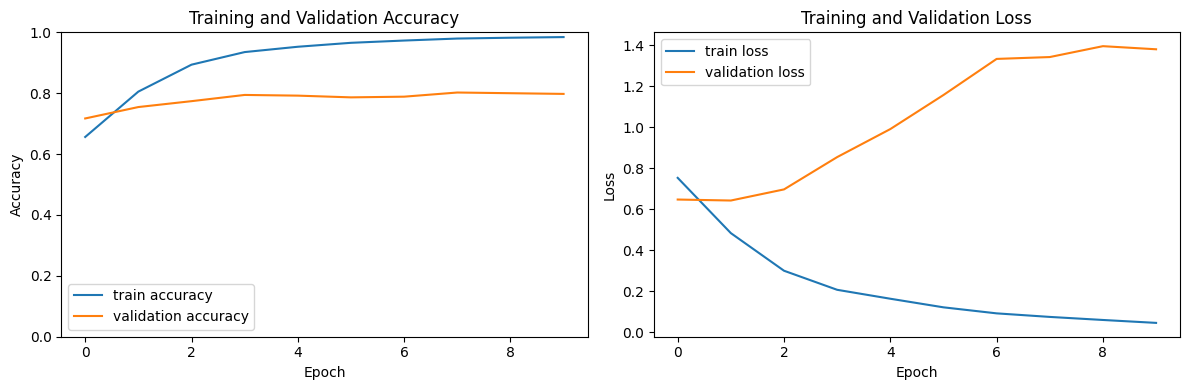

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'history' contains your training history with 'train_acc', 'val_acc', 'train_loss', and 'val_loss'
train_acc = history['train_acc']
val_acc = history['val_acc']
train_loss = history['train_loss']
val_loss = history['val_loss']

# Move tensors from CUDA (GPU) to CPU and convert to NumPy arrays
train_acc = np.array([acc.item() for acc in train_acc])
val_acc = np.array([acc.item() for acc in val_acc])
train_loss = np.array([loss.item() for loss in train_loss])
val_loss = np.array([loss.item() for loss in val_loss])

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()



EVALUATION

In [91]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()


0.8534090909090909

In [92]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [93]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [94]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.86      0.87       301
     neutral       0.74      0.83      0.78       250
    positive       0.93      0.87      0.90       329

    accuracy                           0.85       880
   macro avg       0.85      0.85      0.85       880
weighted avg       0.86      0.85      0.86       880



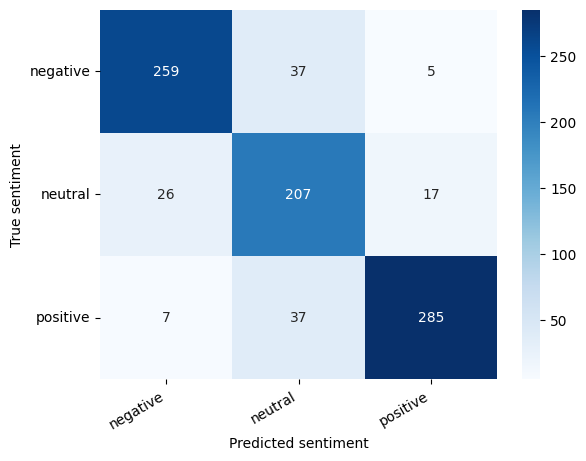

In [95]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [96]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})


In [97]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

perfect for visualizing your day in time blocks!

True sentiment: positive


In [98]:
#Predicting on Raw Text
#Let's use our model to predict the sentiment of some raw text:


review_text = "I love completing my todos! Best app ever!!!"

In [99]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [100]:

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')



Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
